In [1]:
# Tell python where to look for modules. 
# Depending on how your jupyter handles working directories, this may not be needed.
import sys
sys.path.append('../../hourly-egrid/')

In [125]:
# Third party packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dateutil.parser import parse as parse_dt

In [173]:
# import our packages
%reload_ext autoreload
%autoreload 2

import src.data_cleaning as data_cleaning

In [10]:
year = 2019

# Compare to EIA-930
* Compare emisson rate
* Compare total emission 

In [216]:
hourly_emission_rate = pd.read_csv("../data/output/hourly_emission_rate.csv", index_col=0, parse_dates=True)
hourly_net_generation = pd.read_csv("../data/output/hourly_net_generation.csv", index_col=0, parse_dates=True)
hourly_net_emissions = pd.read_csv("../data/output/hourly_net_emission.csv", index_col=0, parse_dates=True)
hourly_emission_rate.head()

,AEC,AECI,AVA,AVRN,AZPS,BANC,BPAT,CISO,CPLE,CSTO,...,SPA,SRP,SWPP,TAL,TEC,TEPC,TIDC,TVA,WACM,WALC
operating_datetime_utc,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.635791,NaN,...,NaN,NaN,NaN,0.527126,0.566509,NaN,NaN,1.037195,NaN,NaN
2019-01-01 06:00:00+00:00,0.659398,0.825115,NaN,NaN,NaN,NaN,NaN,NaN,0.638974,NaN,...,0.953725,NaN,0.913039,0.530544,0.574877,NaN,NaN,0.917874,NaN,NaN
2019-01-01 07:00:00+00:00,0.653285,0.828527,NaN,NaN,0.734201,NaN,NaN,NaN,0.634677,NaN,...,0.941797,0.179249,0.890990,0.534728,0.587271,0.144519,NaN,0.919038,1.015533,0.474256
2019-01-01 08:00:00+00:00,0.682231,0.830951,0.406897,0.422533,0.767095,0.536824,0.726817,0.329878,0.634675,0.42476,...,0.949609,0.152431,0.894900,0.542358,0.598842,0.150057,0.075620,0.945352,1.021793,0.284875
2019-01-01 09:00:00+00:00,0.699115,0.830491,0.408140,0.422533,0.757540,0.573958,0.733141,0.334203,0.637950,0.42304,...,0.953333,0.152233,0.890373,0.543946,0.604369,0.149177,0.077819,0.941008,1.026918,0.293501


In [217]:
eia_930_1 = pd.read_csv(f"../data/eia930/EIA930_BALANCE_{year}_Jan_Jun.csv",\
                        index_col="UTC Time at End of Hour", parse_dates=True, thousands=',')
eia_930_2 = pd.read_csv(f"../data/eia930/EIA930_BALANCE_{year}_Jul_Dec.csv",\
                        index_col="UTC Time at End of Hour", parse_dates=True, thousands=',')
eia_930 = pd.concat([eia_930_1, eia_930_2])
eia_930.head()

,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),Sum(Valid DIBAs) (MW),Demand (MW) (Imputed),...,Net Generation (MW) from Coal,Net Generation (MW) from Natural Gas,Net Generation (MW) from Nuclear,Net Generation (MW) from All Petroleum Products,Net Generation (MW) from Hydropower and Pumped Storage,Net Generation (MW) from Solar,Net Generation (MW) from Wind,Net Generation (MW) from Other Fuel Sources,Net Generation (MW) from Unknown Fuel Sources,Region
UTC Time at End of Hour,,,,,,,,,,,,,,,,,,,,,
2019-01-01 07:00:00,AEC,01/01/2019,1,01/01/2019 1:00:00 AM,NaN,361.0,414.0,53.0,53.0,NaN,...,-5.0,416.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 08:00:00,AEC,01/01/2019,2,01/01/2019 2:00:00 AM,NaN,344.0,376.0,32.0,32.0,NaN,...,-5.0,378.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 09:00:00,AEC,01/01/2019,3,01/01/2019 3:00:00 AM,NaN,326.0,355.0,29.0,29.0,NaN,...,-5.0,357.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 10:00:00,AEC,01/01/2019,4,01/01/2019 4:00:00 AM,NaN,318.0,356.0,38.0,38.0,NaN,...,-5.0,358.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE
2019-01-01 11:00:00,AEC,01/01/2019,5,01/01/2019 5:00:00 AM,NaN,324.0,357.0,33.0,33.0,NaN,...,-3.0,357.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,SE


In [218]:
eia_930 = data_cleaning.clean_eia_930(eia_930)

In [219]:
# Calculate hourly EIA-930 non-renewable generation 
eia_930["930_generation_non_renewable"] = eia_930[["Net Generation (MW) from Coal",\
                                                  "Net Generation (MW) from Natural Gas",\
                                                  "Net Generation (MW) from All Petroleum Products"]].sum(\
                                                  axis=1)

# Calculate hourly EIA-930 non-renewable generation 
eia_930["930_generation_minus_renewable"] = eia_930["Net Generation (MW)"] - \
                                                  eia_930[["Net Generation (MW) from Nuclear",\
                                                  "Net Generation (MW) from Hydropower and Pumped Storage",\
                                                  "Net Generation (MW) from Solar",\
                                                  "Net Generation (MW) from Wind"]].sum(\
                                                  axis=1)

(18109.0, 18118.0)

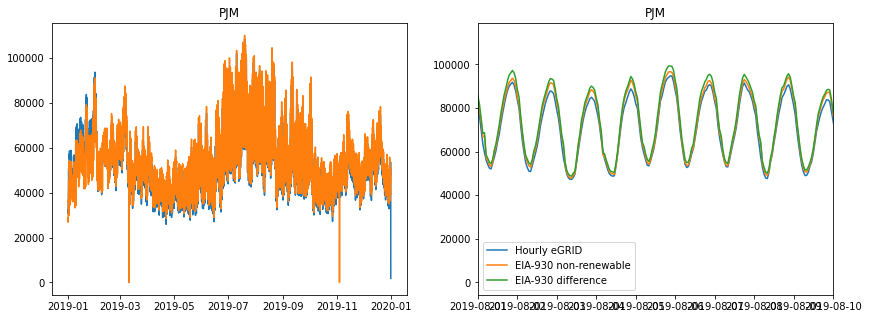

In [232]:
# large BAs with significant discrepancies between eGRID and aggregated CEMS data: PJM, MISO, ERCO
# BAs with bad 930 data: PGE, AVRN, BPAT, "FPL","IPCO","NEVP","SC","TEC","TVA"
ba = "PJM"

fig, (ax, ax2) = plt.subplots(1,2, figsize=(14,5))

ax.plot(hourly_net_generation[ba], label="Hourly eGRID")
ax.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_non_renewable"])
ax.set_title(ba)

ax2.plot(hourly_net_generation[ba], label="Hourly eGRID")
ax2.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_non_renewable"], label="EIA-930 non-renewable")
ax2.plot(eia_930[eia_930["Balancing Authority"]==ba]["930_generation_minus_renewable"], label="EIA-930 difference")
ax2.set_title(ba)
ax2.legend()
ax2.set_xlim(parse_dt("2019-08-01"), parse_dt("2019-08-10"))

### Annual EIA-930

Hourly EIA-930 appears to be in good agreement with hourly eGRID numbers, even in areas like PJM where hourly eGRID covers only 60% of actual eGRID non-renewable generation. Is this something about aggregation, or a difference between EIA-930 and actual eGRID? 

In [221]:
# For annual comparison graphs, see below with eGRID
annual_eia_930 = eia_930.groupby("Balancing Authority").sum()[["930_generation_non_renewable","930_generation_minus_renewable"]]
annual_eia_930.head()

,930_generation_non_renewable,930_generation_minus_renewable
Balancing Authority,,
AEC,3194361.0,3199154.0
AECI,22953634.0,22953740.0
AVA,2047287.0,2909232.0
AVRN,716633.0,716633.0
BANC,30464309.0,29915647.0


# Compare to eGRID 
* Compare annual aggregated generation, emission, and emission rate

In [222]:
egrid = pd.read_excel(f"../data/egrid/egrid{year}_data.xlsx", sheet_name=f"BA{year-2000}", header=1, index_col="BACODE")
egrid.head()

,YEAR,BANAME,BANAMEPCAP,BAHTIAN,BAHTIOZ,BAHTIANT,BAHTIOZT,BANGENAN,BANGENOZ,BANOXAN,...,BANBOLPR,BANBGSPR,BANBNCPR,BANBHYPR,BANBBMPR,BANBWIPR,BANBSOPR,BANBGTPR,BANBOFPR,BANBOPPR
BACODE,,,,,,,,,,,,,,,,,,,,,
NaN,2019,Alaska Miscellaneous,2319.8,2.768102e+07,1.066677e+07,4.086632e+07,1.638851e+07,4.252137e+06,1713768.396,18164.768,...,0.650413,0.312594,0.0,0.0,0.001542,0.0,0.0,0.0,0.0,0.0
YAD,2019,"Alcoa Power Generating, Inc. - Yadkin Division",215.2,0.000000e+00,0.000000e+00,9.140289e+06,3.140862e+06,1.026422e+06,352708.001,0.000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
AMPL,2019,Anchorage Municipal Light & Power,595.3,6.034108e+06,2.192372e+06,7.734705e+06,2.936194e+06,8.687949e+05,321840.995,896.072,...,0.000000,0.960046,0.0,0.0,0.039954,0.0,0.0,0.0,0.0,0.0
AZPS,2019,Arizona Public Service Company,10359.0,1.605243e+08,7.427169e+07,1.818162e+08,8.543783e+07,1.854227e+07,8715085.998,6670.740,...,0.000005,0.340409,0.0,0.0,0.000690,0.0,0.0,0.0,0.0,0.0
DEAA,2019,"Arlington Valley, LLC - AVBA",713.0,2.142691e+07,1.031609e+07,2.142691e+07,1.031609e+07,2.928495e+06,1398136.000,81.435,...,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [223]:
## Get names (row 0 of egrid) and codes (row 1) for each eGRID data type
## We use data codes as columns (above), but mapping back to names is useful 
egrid_data_code_to_name = pd.read_excel(f"../data/egrid/egrid{year}_data.xlsx", sheet_name=f"BA{year-2000}", nrows=1)
egrid_data_code_to_name = dict([(egrid_data_code_to_name.loc[0,name], name) for name in egrid_data_code_to_name.columns])

In [224]:
# Merge summed hourly eGRID generation and annual eGRID non-renuable net generation
annual_generation = hourly_net_generation.sum(axis=0).rename("hourly")
annual_generation = egrid.merge(annual_generation, how='right', left_index=True, right_index=True).loc[:,["hourly","BAGENACY"]]

In [225]:
# Merge aggregated 930 
annual_generation = annual_generation.merge(annual_eia_930, how="left", left_index=True, right_index=True)

In [226]:
annual_generation.head()

,hourly,BAGENACY,930_generation_non_renewable,930_generation_minus_renewable
AEC,4.268174e+06,5.212921e+06,3194361.0,3199154.0
AECI,2.723725e+07,2.632081e+07,22953634.0,22953740.0
AVA,1.999215e+06,2.969388e+06,2047287.0,2909232.0
AVRN,3.500520e+06,3.393744e+06,716633.0,716633.0
AZPS,1.609298e+07,1.615126e+07,NaN,NaN


/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2436023855.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=annual_generation.index, rotation=90);
/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2436023855.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=annual_generation.index, rotation=90);
/var/folders/mr/3dcnnc3153j6s05bmdwr0r0h0000gq/T/ipykernel_85695/2436023855.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels=annual_generation.index, rotation=90);


AttributeError: 'AxesSubplot' object has no attribute 'set_ylimits'

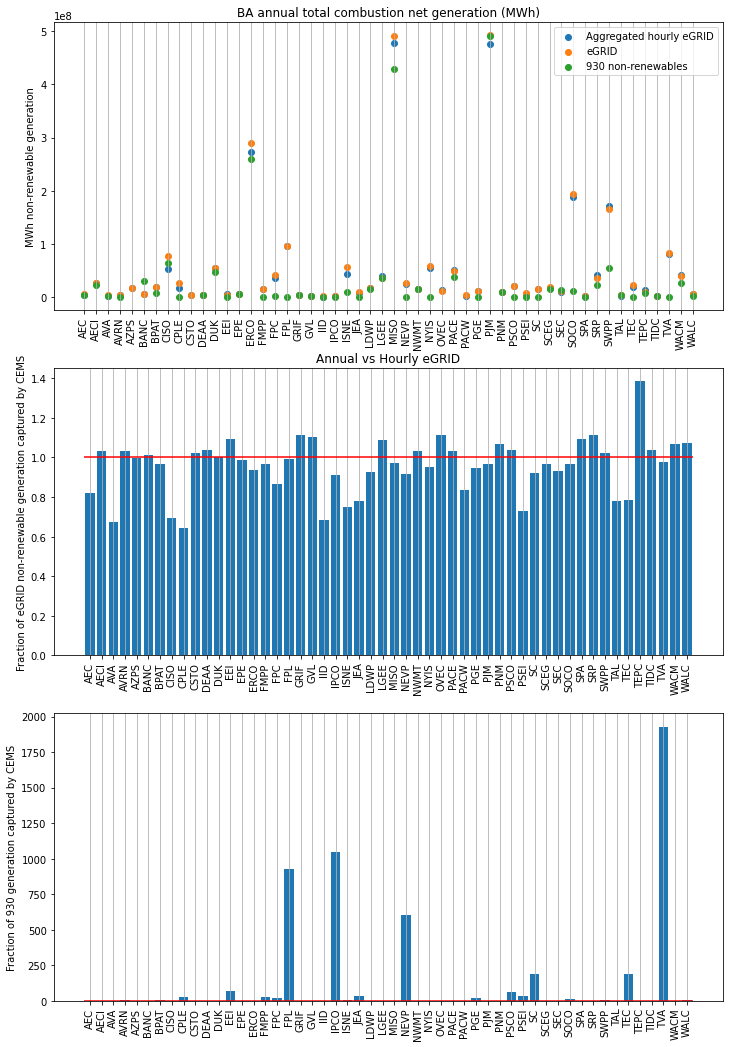

In [234]:
fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(12,18))

ax.scatter(annual_generation.index, annual_generation["hourly"].tolist(), label="Aggregated hourly eGRID")
ax.scatter(annual_generation.index, annual_generation["BAGENACY"].tolist(), label="eGRID")
ax.scatter(annual_generation.index, annual_generation["930_generation_non_renewable"].tolist(), label="930 non-renewables")
ax.legend()
ax.grid(axis='x')
ax.set_title(f"{egrid_data_code_to_name['BAGENACY']}")
ax.set_xticklabels(labels=annual_generation.index, rotation=90);
ax.set_ylabel("MWh non-renewable generation")

# small = annual_generation[annual_generation["BAGENATN"] < 1e8]
# ax2.scatter(small.index, small["hourly"].tolist())
# ax2.scatter(small.index, small["BAGENATN"].tolist())
# ax2.grid(axis='x')
# ax2.set_title("BAs under 100,000,000 MWh annual")
# ax2.set_xticklabels(labels=small.index, rotation=90);

ax2.bar(annual_generation.index, annual_generation["hourly"]/annual_generation["BAGENACY"])
ax2.grid(axis='x')
ax2.set_xticklabels(labels=annual_generation.index, rotation=90);
ax2.hlines([1.0], -.5, len(annual_generation)-0.5, color='r')
ax2.set_ylabel("Fraction of eGRID non-renewable generation captured by CEMS");
ax2.set_title("Annual vs Hourly eGRID")

ax3.bar(annual_generation.index, annual_generation["hourly"]/annual_generation["930_generation_non_renewable"])
ax3.grid(axis='x')
ax3.set_xticklabels(labels=annual_generation.index, rotation=90);
ax3.hlines([1.0], -.5, len(annual_generation)-0.5, color='r')
ax3.set_ylabel("Fraction of 930 generation captured by CEMS");
ax3.set_ylimits(0,2)
ax3.set_title("EIA-930 vs hourly eGRID")

In [230]:
annual_generation.loc[["FPL","IPCO","NEVP","SC","TEC","TVA"],:]

,hourly,BAGENACY,930_generation_non_renewable,930_generation_minus_renewable
FPL,9.578461e+07,9.636939e+07,103479.0,118116.0
IPCO,2.155937e+06,2.364719e+06,2053.0,2318.0
NEVP,2.505629e+07,2.731401e+07,41456.0,47816.0
SC,1.432241e+07,1.552237e+07,76362.0,75027.0
TEC,1.846835e+07,2.348435e+07,99507.0,189157.0
TVA,8.013121e+07,8.214065e+07,41558.0,42154.0
